##**Calculating Volatility of Stocks**




**Stock volatility is the degree to which stock prices and market indexes change over time. Stocks with dramatic price swings, such as new highs and lows, are considered highly volatile. A stock with a relatively stable price has low volatility.**

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
from google.colab import drive
import os
import csv
from math import sqrt

# Define function to parse CSV line
def parse_csv_line(line):
    return next(csv.reader([line]))

# Define function to calculate returns
def calculate_returns(adj_close_prices):
    returns = [(adj_close_prices[i] - adj_close_prices[i-1]) / adj_close_prices[i-1] for i in range(1, len(adj_close_prices))]
    return returns

# Define function to calculate volatility
def calculate_volatility(returns):
    if not returns:  # Check if the list of returns is empty
        return None
    # Calculate the mean return
    mean_return = sum(returns) / len(returns)
    # Calculate the sum of squared differences between each return and the mean return
    sum_squared_diff = sum((return_ - mean_return) ** 2 for return_ in returns)
    # Calculate the variance
    variance = sum_squared_diff / len(returns)
    # Calculate the volatility (standard deviation)
    volatility = sqrt(variance)
    return volatility

# Iterate over CSV files
stocks_folder = '/content/drive/MyDrive/stocks'
volatility_data = {}

for file_name in os.listdir(stocks_folder):
    file_path = os.path.join(stocks_folder, file_name)
    if file_path.endswith('.csv'):
        with open(file_path, 'r') as file:
            next(file)  # Skip the first line (column names)
            adj_close_prices = [float(parse_csv_line(line)[5]) for line in file]
            returns = calculate_returns(adj_close_prices)
            volatility = calculate_volatility(returns)
            if volatility is not None:  # Check if volatility is calculated
                volatility_data[file_name.split('.')[0]] = volatility

# Sort the stocks based on volatility
sorted_volatility = sorted(volatility_data.items(), key=lambda x: x[1])

# Output the top 10 and bottom 10 volatile stocks
top_10 = sorted_volatility[-10:]
bottom_10 = sorted_volatility[:10]

# Write data to CSV file
csv_file_path = '/content/drive/MyDrive/volatility_of_Stockdata.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Stock', 'Volatility']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for stock_name, volatility in volatility_data.items():
        writer.writerow({'Stock': stock_name, 'Volatility': volatility})

print("Top 10 volatile stocks:")
for stock_name, volatility in top_10:
    print(f"{stock_name}: {volatility}")

print("\nBottom 10 volatile stocks:")
for stock_name, volatility in bottom_10:
    print(f"{stock_name}: {volatility}")


Top 10 volatile stocks:
ACCD: 1.7069079574680452
CVE: 1.9319705383921855
CODA: 1.992318756301405
ATXG: 2.2109826569631825
AMPY: 2.923244834636972
CHRD: 4.35516216606057
BCAN: 5.966565136202249
BTCS: 11.359641702724502
BTTR: 18.006567499322095
ABVC: 59.50464553977696

Bottom 10 volatile stocks:
ANSC: 0.0007868630717351416
DYCQ: 0.0009580414232137578
AITR: 0.0010388185454128294
AACT: 0.0013040216846822337
AFJK: 0.0013202043118592931
BKHAU: 0.0013219074063541107
BAYA: 0.0014254068923440874
BOCN: 0.0014809889549399103
ALCY: 0.0015541319220112987
BOWN: 0.0016155531690422464


In [10]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4d4a0b5282a8576c6044927d33c4508f3c280ad6c00b3e6a3ab4ad8d3c8ec72c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [11]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("StockVolatilityAnalysis") \
    .getOrCreate()

# Load the CSV file into a DataFrame
csv_file_path = '/content/drive/MyDrive/volatility_of_Stockdata.csv'  # Replace with the actual path to your CSV file
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show the DataFrame schema and first few rows
df.printSchema()
df.show()


root
 |-- Stock: string (nullable = true)
 |-- Volatility: double (nullable = true)

+-----+--------------------+
|Stock|          Volatility|
+-----+--------------------+
| BSTZ|0.020326869601223607|
| BSRR|0.037529736090293614|
|  BST| 0.01622887983250533|
| BSVN| 0.03212229301619287|
|  BSY|0.026148420341630153|
|  BSX|0.024138784223126514|
|  BTA|0.009893136659484773|
| BTAI| 0.06875416036076457|
| BTBD| 0.06560336107945047|
| BTBT| 0.09036509434106749|
| BTCM| 0.06010002020035351|
| BTCT|  0.5577248771413365|
| BTCS|  11.359641702724502|
| BTCY| 0.12665897150543381|
| BTDR| 0.05751091322295747|
|  BTE|0.038083593082453175|
|  BTG|0.037537956648316335|
|  BTI|0.019331238219601275|
|  BTM| 0.04655114532316333|
|  BTO|0.025135806158476427|
+-----+--------------------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import min, max

# Compute the minimum and maximum volatility
min_volatility = df.agg(min("Volatility")).collect()[0][0]
max_volatility = df.agg(max("Volatility")).collect()[0][0]

print("Range of volatility:")
print("Minimum Volatility:", min_volatility)
print("Maximum Volatility:", max_volatility)


Range of volatility:
Minimum Volatility: 0.0007868630717351416
Maximum Volatility: 59.50464553977696


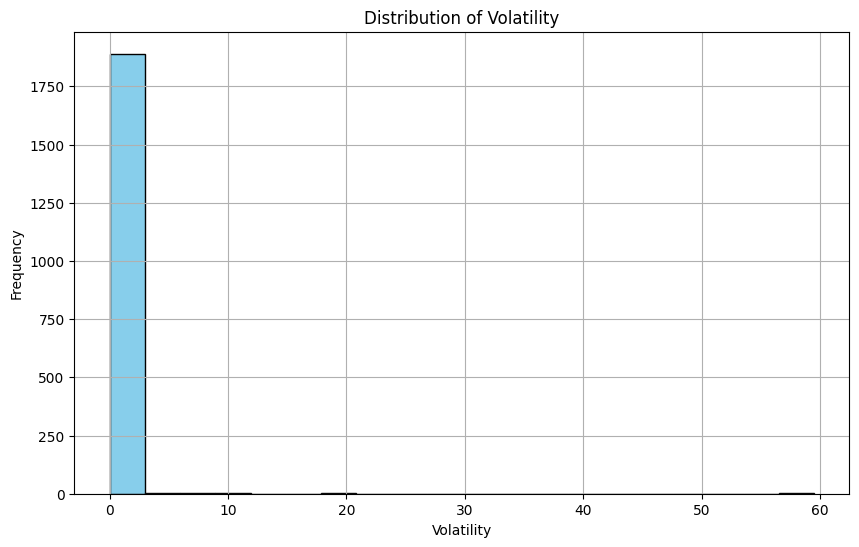

In [13]:
import matplotlib.pyplot as plt

# Extract volatility values as a list
volatility_values = df.select("Volatility").rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(volatility_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
